# 모델 후보
- 라쏘
- 릿지 / 베이지안 릿지
- xgboost
- randomforest
- catboost (binning)
- 시계열 AR(1) : SARIMAX
- lightGBM
- stackerd hybrid

In [ ]:
# 폰트 깨짐 방지
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
import statsmodels.graphics.tsaplots as sgt

import warnings

# 모든 경고 메시지 끄기
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install optuna
# !pip install catboost
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

import re
import optuna
from optuna.integration import XGBoostPruningCallback

from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor , GradientBoostingRegressor

In [ ]:
# out of sampel forecasting

# 1.데이터 불러오기

In [ ]:
data1 = pd.read_csv("/content/drive/MyDrive/삼성화재&Postech 데이터 리스크 /데이터/서리/최종_서리_데이터.csv", encoding="cp949")
data1['서리끝'] = pd.to_datetime(data1['서리끝'])
data1 = pd.get_dummies(data1, columns=['해양'])


In [ ]:
data1

,지점,서리끝,서리끝(평비),365,연,위도,경도,고도,2_일교차_mean,3_일교차_mean,...,3_평균 전운량(1/10)_std,4_평균 전운량(1/10)_std,2_평균 풍속(m/s)_mean,3_평균 풍속(m/s)_mean,4_평균 풍속(m/s)_mean,2_평균 풍속(m/s)_std,3_평균 풍속(m/s)_std,4_평균 풍속(m/s)_std,해양_0.0,해양_1.0
0,강릉,1989-03-26,3.45,85,1989,37.762825,128.9357,26.29,7.710714,7.745161,...,3.243143,2.842261,2.446429,2.590323,2.383333,0.823489,1.266058,0.700780,0,1
1,강릉,1990-03-26,3.45,85,1990,37.762825,128.9357,26.29,5.928571,8.577419,...,3.302821,3.539935,1.871429,2.500000,2.806667,1.167097,1.117438,1.415172,0,1
2,강릉,1991-04-02,10.45,92,1991,37.762825,128.9357,26.29,8.028571,7.535484,...,3.250992,3.445011,2.903571,2.148387,2.300000,1.147455,1.070162,0.918019,0,1
3,강릉,1992-03-19,-2.55,79,1992,37.762825,128.9357,26.29,9.017241,8.132258,...,3.390264,3.368099,3.124138,1.890323,2.760000,0.870408,0.633695,1.193257,0,1
4,강릉,1993-04-12,20.45,102,1993,37.762825,128.9357,26.29,8.457143,8.864516,...,3.295259,3.439721,3.135714,2.596774,2.836667,1.102258,0.997826,1.219520,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,충주,2010-04-17,4.00,107,2010,36.970500,127.9525,114.85,9.835714,8.916129,...,3.015266,3.374584,1.364286,2.032258,2.106667,0.735962,0.857666,0.928823,1,0
1918,충주,2011-04-13,0.00,103,2011,36.970500,127.9525,114.85,12.982143,12.287097,...,2.242586,3.271199,1.278571,2.167742,1.930000,0.668529,0.822754,0.565777,1,0
1919,충주,2012-04-08,-5.00,99,2012,36.970500,127.9525,114.85,12.327586,10.035484,...,3.112834,3.351642,1.613793,2.135484,2.183333,0.850934,0.944298,0.985090,1,0
1920,충주,2013-04-13,0.00,103,2013,36.970500,127.9525,114.85,10.600000,14.000000,...,2.215444,2.864364,1.675000,1.761290,2.180000,0.939907,0.713992,0.825624,1,0


#### 1.1데이터 기본정보 확인

In [ ]:
data1.columns

Index(['지점', '서리끝', '서리끝(평비)', '365', '연', '위도', '경도', '고도', '2_일교차_mean',
       '3_일교차_mean', '4_일교차_mean', '2_일교차_std', '3_일교차_std', '4_일교차_std',
       '2_최저 초상온도(°C)_mean', '3_최저 초상온도(°C)_mean', '4_최저 초상온도(°C)_mean',
       '2_최저 초상온도(°C)_min', '3_최저 초상온도(°C)_min', '4_최저 초상온도(°C)_min',
       '2_최저 초상온도(°C)_std', '3_최저 초상온도(°C)_std', '4_최저 초상온도(°C)_std',
       '2_최저기온(°C)_mean', '3_최저기온(°C)_mean', '4_최저기온(°C)_mean',
       '2_최저기온(°C)_min', '3_최저기온(°C)_min', '4_최저기온(°C)_min', '2_최저기온(°C)_std',
       '3_최저기온(°C)_std', '4_최저기온(°C)_std', '2_평균 상대습도(%)_mean',
       '3_평균 상대습도(%)_mean', '4_평균 상대습도(%)_mean', '2_평균 상대습도(%)_std',
       '3_평균 상대습도(%)_std', '4_평균 상대습도(%)_std', '2_평균 이슬점온도(°C)_mean',
       '3_평균 이슬점온도(°C)_mean', '4_평균 이슬점온도(°C)_mean', '2_평균 이슬점온도(°C)_min',
       '3_평균 이슬점온도(°C)_min', '4_평균 이슬점온도(°C)_min', '2_평균 이슬점온도(°C)_std',
       '3_평균 이슬점온도(°C)_std', '4_평균 이슬점온도(°C)_std', '2_평균 전운량(1/10)_mean',
       '3_평균 전운량(1/10)_mean', '4_평균 전운량(1/10)_mean', '2_평균 전운량(1/10)_s

In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922 entries, 0 to 1921
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   지점                   1922 non-null   object        
 1   서리끝                  1922 non-null   datetime64[ns]
 2   서리끝(평비)              1922 non-null   float64       
 3   365                  1922 non-null   int64         
 4   연                    1922 non-null   int64         
 5   위도                   1922 non-null   float64       
 6   경도                   1922 non-null   float64       
 7   고도                   1922 non-null   float64       
 8   2_일교차_mean           1922 non-null   float64       
 9   3_일교차_mean           1922 non-null   float64       
 10  4_일교차_mean           1922 non-null   float64       
 11  2_일교차_std            1922 non-null   float64       
 12  3_일교차_std            1922 non-null   float64       
 13  4_일교차_std            1922 non-nul

#### 1.2결측값 확인

In [ ]:
data1.isnull().sum()

지점                  0
서리끝                 0
서리끝(평비)             0
365                 0
연                   0
                   ..
2_평균 풍속(m/s)_std    0
3_평균 풍속(m/s)_std    0
4_평균 풍속(m/s)_std    0
해양_0.0              0
해양_1.0              0
Length: 61, dtype: int64

#### 1.3지점별로 최적의 변수찾기

select k best

In [ ]:
df = data1.copy()

In [ ]:
df

,지점,서리끝,서리끝(평비),365,연,위도,경도,고도,2_일교차_mean,3_일교차_mean,...,3_평균 전운량(1/10)_std,4_평균 전운량(1/10)_std,2_평균 풍속(m/s)_mean,3_평균 풍속(m/s)_mean,4_평균 풍속(m/s)_mean,2_평균 풍속(m/s)_std,3_평균 풍속(m/s)_std,4_평균 풍속(m/s)_std,해양_0.0,해양_1.0
0,강릉,1989-03-26,3.45,85,1989,37.762825,128.9357,26.29,7.710714,7.745161,...,3.243143,2.842261,2.446429,2.590323,2.383333,0.823489,1.266058,0.700780,0,1
1,강릉,1990-03-26,3.45,85,1990,37.762825,128.9357,26.29,5.928571,8.577419,...,3.302821,3.539935,1.871429,2.500000,2.806667,1.167097,1.117438,1.415172,0,1
2,강릉,1991-04-02,10.45,92,1991,37.762825,128.9357,26.29,8.028571,7.535484,...,3.250992,3.445011,2.903571,2.148387,2.300000,1.147455,1.070162,0.918019,0,1
3,강릉,1992-03-19,-2.55,79,1992,37.762825,128.9357,26.29,9.017241,8.132258,...,3.390264,3.368099,3.124138,1.890323,2.760000,0.870408,0.633695,1.193257,0,1
4,강릉,1993-04-12,20.45,102,1993,37.762825,128.9357,26.29,8.457143,8.864516,...,3.295259,3.439721,3.135714,2.596774,2.836667,1.102258,0.997826,1.219520,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,충주,2010-04-17,4.00,107,2010,36.970500,127.9525,114.85,9.835714,8.916129,...,3.015266,3.374584,1.364286,2.032258,2.106667,0.735962,0.857666,0.928823,1,0
1918,충주,2011-04-13,0.00,103,2011,36.970500,127.9525,114.85,12.982143,12.287097,...,2.242586,3.271199,1.278571,2.167742,1.930000,0.668529,0.822754,0.565777,1,0
1919,충주,2012-04-08,-5.00,99,2012,36.970500,127.9525,114.85,12.327586,10.035484,...,3.112834,3.351642,1.613793,2.135484,2.183333,0.850934,0.944298,0.985090,1,0
1920,충주,2013-04-13,0.00,103,2013,36.970500,127.9525,114.85,10.600000,14.000000,...,2.215444,2.864364,1.675000,1.761290,2.180000,0.939907,0.713992,0.825624,1,0


In [ ]:
df= df.drop(columns=['서리끝','서리끝(평비)','연'])
df

,지점,365,위도,경도,고도,2_일교차_mean,3_일교차_mean,4_일교차_mean,2_일교차_std,3_일교차_std,...,3_평균 전운량(1/10)_std,4_평균 전운량(1/10)_std,2_평균 풍속(m/s)_mean,3_평균 풍속(m/s)_mean,4_평균 풍속(m/s)_mean,2_평균 풍속(m/s)_std,3_평균 풍속(m/s)_std,4_평균 풍속(m/s)_std,해양_0.0,해양_1.0
0,강릉,85,37.762825,128.9357,26.29,7.710714,7.745161,11.206667,3.079363,2.835823,...,3.243143,2.842261,2.446429,2.590323,2.383333,0.823489,1.266058,0.700780,0,1
1,강릉,85,37.762825,128.9357,26.29,5.928571,8.577419,9.423333,3.004793,2.628271,...,3.302821,3.539935,1.871429,2.500000,2.806667,1.167097,1.117438,1.415172,0,1
2,강릉,92,37.762825,128.9357,26.29,8.028571,7.535484,10.540000,2.403525,3.416582,...,3.250992,3.445011,2.903571,2.148387,2.300000,1.147455,1.070162,0.918019,0,1
3,강릉,79,37.762825,128.9357,26.29,9.017241,8.132258,9.230000,2.212799,4.233626,...,3.390264,3.368099,3.124138,1.890323,2.760000,0.870408,0.633695,1.193257,0,1
4,강릉,102,37.762825,128.9357,26.29,8.457143,8.864516,8.986667,2.501174,2.926835,...,3.295259,3.439721,3.135714,2.596774,2.836667,1.102258,0.997826,1.219520,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,충주,107,36.970500,127.9525,114.85,9.835714,8.916129,12.546667,5.058708,4.233052,...,3.015266,3.374584,1.364286,2.032258,2.106667,0.735962,0.857666,0.928823,1,0
1918,충주,103,36.970500,127.9525,114.85,12.982143,12.287097,13.590000,4.516722,3.787413,...,2.242586,3.271199,1.278571,2.167742,1.930000,0.668529,0.822754,0.565777,1,0
1919,충주,99,36.970500,127.9525,114.85,12.327586,10.035484,13.483333,2.801262,4.174410,...,3.112834,3.351642,1.613793,2.135484,2.183333,0.850934,0.944298,0.985090,1,0
1920,충주,103,36.970500,127.9525,114.85,10.600000,14.000000,12.553333,3.295227,4.009156,...,2.215444,2.864364,1.675000,1.761290,2.180000,0.939907,0.713992,0.825624,1,0


In [ ]:
1988 - 2022

23.4390243902439

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression


# 모든 지점에 대해 선택된 변수와 점수를 저장할 딕셔너리 생성
selected_variables = {}

# 각 지점별로 변수 선택을 수행하고 결과를 저장
unique_locations = df['지점'].unique()
for location in unique_locations:
    selected_location = location
    selected_data = df[df['지점'] == selected_location]
    selected_data = selected_data.drop(columns=['지점'])

    # 특성 선택을 위한 SelectKBest 객체 생성
    # 여기서는 f_regression을 사용하여 변수 선택
    k_best = SelectKBest(score_func=f_regression, k=10)  # k는 선택할 변수의 개수를 지정합니다.

    # 변수 선택 수행
    X_new = k_best.fit_transform(selected_data.drop(columns=['365']), selected_data.iloc[:, 0])

    # 선택된 변수의 인덱스를 가져옴
    selected_feature_indices = k_best.get_support(indices=True)

    # 선택된 변수 목록을 저장
    selected_features = selected_data.columns[selected_feature_indices]

    # 선택된 변수의 점수를 저장
    selected_scores = k_best.scores_

    # 결과를 딕셔너리에 저장하며 점수 소수 네 번째 자리에서 버림
    selected_scores = [round(score, 4) for score in selected_scores]

    # 결과를 딕셔너리에 저장
    selected_variables[selected_location] = {
        '변수': selected_features,
        '점수': selected_scores
    }

# # 각 지점에서 선택된 변수와 점수 출력
# for location, data in selected_variables.items():
#     print(f'지점 {location}에서 선택된 변수: {data["변수"]}')
#     for variable, score in zip(data['변수'], data['점수']):
#         print(f'변수: {variable}, 점수: {score}')



In [ ]:
for location, data in selected_variables.items():
  print(f'지점 {location}에서 선택된 변수: {data["변수"]}')

지점 강릉에서 선택된 변수: Index(['4_일교차_std', '2_최저 초상온도(°C)_mean', '3_최저 초상온도(°C)_mean',
       '3_최저 초상온도(°C)_min', '2_최저기온(°C)_mean', '3_최저기온(°C)_mean',
       '2_최저기온(°C)_std', '2_평균 상대습도(%)_mean', '2_평균 전운량(1/10)_std',
       '2_평균 풍속(m/s)_mean'],
      dtype='object')
지점 대관령에서 선택된 변수: Index(['2_일교차_mean', '3_일교차_std', '4_일교차_std', '3_최저 초상온도(°C)_min',
       '2_최저기온(°C)_std', '2_평균 상대습도(%)_mean', '4_평균 상대습도(%)_mean',
       '3_평균 이슬점온도(°C)_min', '2_평균 전운량(1/10)_mean', '4_평균 전운량(1/10)_mean'],
      dtype='object')
지점 동해에서 선택된 변수: Index(['3_일교차_mean', '3_최저 초상온도(°C)_mean', '2_최저 초상온도(°C)_std',
       '3_최저기온(°C)_mean', '2_최저기온(°C)_std', '4_최저기온(°C)_std',
       '2_평균 상대습도(%)_mean', '2_평균 이슬점온도(°C)_mean', '2_평균 이슬점온도(°C)_std',
       '4_평균 전운량(1/10)_std'],
      dtype='object')
지점 북강릉에서 선택된 변수: Index(['2_일교차_mean', '2_최저 초상온도(°C)_std', '4_최저 초상온도(°C)_std',
       '3_최저기온(°C)_min', '2_평균 상대습도(%)_std', '3_평균 상대습도(%)_std',
       '2_평균 이슬점온도(°C)_std', '2_평균 전운량(1/10)_std', '2_평균 풍속(m/s)_mean',
 

In [ ]:
# 지점 -> 최적 변수 -> 지점별로 모델 fit 각 모델 score 평균 최종 score -> 다른모델과 비교

그래피컬 모델로 변수간 관계 시각화

In [ ]:
# !pip install pgmpy
# !pip install networkx

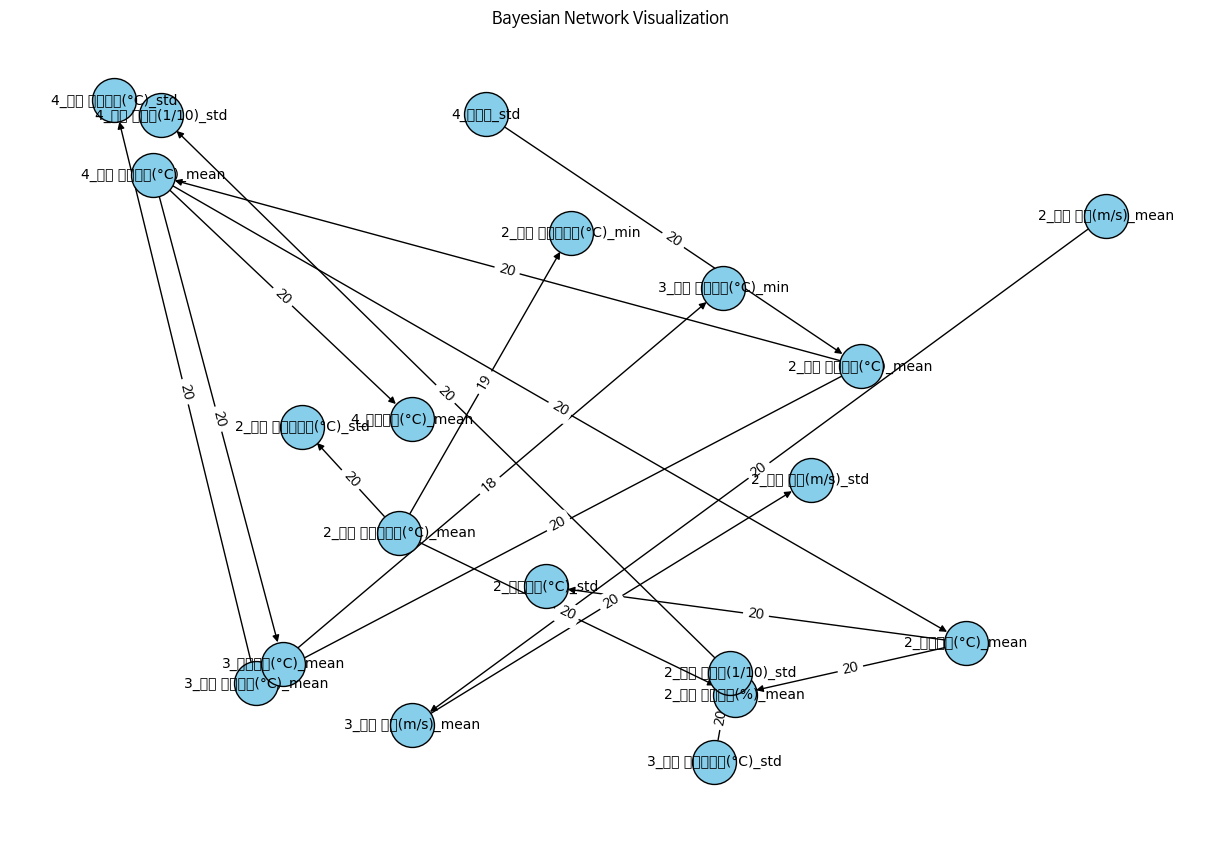

In [ ]:
# 필요한 라이브러리를 가져옵니다
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ParameterEstimator
from pgmpy.inference import VariableElimination
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 그래프 폰트 설정
# font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # 사용하는 운영체제에 따라 경로가 다를 수 있습니다.
# font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

best_var=['4_일교차_std', '2_최저 초상온도(°C)_mean', '3_최저 초상온도(°C)_mean',
       '4_최저 초상온도(°C)_mean', '3_최저 초상온도(°C)_min', '4_최저 초상온도(°C)_std',
       '2_최저기온(°C)_mean', '3_최저기온(°C)_mean', '4_최저기온(°C)_mean',
       '2_최저기온(°C)_std', '2_평균 상대습도(%)_mean', '2_평균 이슬점온도(°C)_mean',
       '2_평균 이슬점온도(°C)_min', '2_평균 이슬점온도(°C)_std', '3_평균 이슬점온도(°C)_std',
       '2_평균 전운량(1/10)_std', '4_평균 전운량(1/10)_std', '2_평균 풍속(m/s)_mean',
       '3_평균 풍속(m/s)_mean', '2_평균 풍속(m/s)_std']
df_강릉 = data1[data1['지점']=='강릉']

df_강릉_k = df_강릉[best_var]
# Bayesian Network 모델 생성 및 변수 간의 관계 지정
model = BayesianNetwork([
    ('4_일교차_std', '2_최저 초상온도(°C)_mean'),
    ('2_최저 초상온도(°C)_mean', '3_최저 초상온도(°C)_mean'),
    ('2_최저 초상온도(°C)_mean', '4_최저 초상온도(°C)_mean'),
    ('3_최저 초상온도(°C)_mean', '3_최저 초상온도(°C)_min'),
    ('3_최저 초상온도(°C)_mean', '4_최저 초상온도(°C)_std'),
    ('4_최저 초상온도(°C)_mean', '2_최저기온(°C)_mean'),
    ('4_최저 초상온도(°C)_mean', '3_최저기온(°C)_mean'),
    ('4_최저 초상온도(°C)_mean', '4_최저기온(°C)_mean'),
    ('2_최저기온(°C)_mean', '2_최저기온(°C)_std'),
    ('2_최저기온(°C)_mean', '2_평균 상대습도(%)_mean'),
    ('2_평균 이슬점온도(°C)_mean', '2_평균 상대습도(%)_mean'),
    ('2_평균 이슬점온도(°C)_mean', '2_평균 이슬점온도(°C)_min'),
    ('2_평균 이슬점온도(°C)_mean', '2_평균 이슬점온도(°C)_std'),
    ('3_평균 이슬점온도(°C)_std', '2_평균 전운량(1/10)_std'),
    ('2_평균 전운량(1/10)_std', '4_평균 전운량(1/10)_std'),
    ('2_평균 풍속(m/s)_mean', '3_평균 풍속(m/s)_mean'),
    ('3_평균 풍속(m/s)_mean', '2_평균 풍속(m/s)_std')
])

# Parameter Estimation (조건부 확률 추정)
# 여기서는 가장 간단한 Maximum Likelihood Estimators(MLE)를 사용합니다.
model.fit(df_강릉_k)

# NetworkX 그래프로 시각화
plt.figure(figsize=(12, 8))
# 원하는 레이아웃 알고리즘을 선택하여 사용합니다.
# 여기에서는 random_layout을 사용합니다.
pos = nx.random_layout(model, seed=42)  # 그래프 레이아웃 설정
# 노드와 엣지의 스타일 설정
node_style = {
    "node_size": 1000,  # 노드 크기 조정
    "node_color": "skyblue",  # 노드 색상
    "edgecolors": "black",  # 노드 테두리 색상
    "linewidths": 1,  # 테두리 두께
}
nx.draw(model, pos, with_labels=True, font_size=10, font_color="black", **node_style)
edge_labels = {(i, j): model.get_cpds(j).variable_card for i, j in model.edges()}
nx.draw_networkx_edge_labels(model, pos, edge_labels=edge_labels,font_family = 'NanumBarunGothic')
plt.title("Bayesian Network Visualization")  # 폰트 설정은 이미 plt.rc로 적용됨
plt.show()



In [ ]:
# # 지점으로 그룹화
# grouped = data.groupby('지점')

# def extract_high_correlation_variables(correlation_matrix, threshold=0.7):
#     high_correlation_vars = set()
#     for i in range(len(correlation_matrix.columns)):
#         for j in range(i):
#             if abs(correlation_matrix.iloc[i, j]) >= threshold:
#                 var1 = correlation_matrix.columns[i]
#                 var2 = correlation_matrix.columns[j]
#                 high_correlation_vars.add(var1)
#                 high_correlation_vars.add(var2)
#     return high_correlation_vars

# # 각 지점별로 변수 간 상관 관계 계산 및 높은 상관 관계를 가진 변수 추출
# for name, group in grouped:
#     correlation_matrix = group.corr()
#     high_correlation_vars = extract_high_correlation_variables(correlation_matrix)
#     print(f'지점 {name} 상관 관계가 높은 변수: {high_correlation_vars}\n')

In [ ]:
df

,지점,365,위도,경도,고도,2_일교차_mean,3_일교차_mean,4_일교차_mean,2_일교차_std,3_일교차_std,...,3_평균 전운량(1/10)_std,4_평균 전운량(1/10)_std,2_평균 풍속(m/s)_mean,3_평균 풍속(m/s)_mean,4_평균 풍속(m/s)_mean,2_평균 풍속(m/s)_std,3_평균 풍속(m/s)_std,4_평균 풍속(m/s)_std,해양_0.0,해양_1.0
0,강릉,85,37.762825,128.9357,26.29,7.710714,7.745161,11.206667,3.079363,2.835823,...,3.243143,2.842261,2.446429,2.590323,2.383333,0.823489,1.266058,0.700780,0,1
1,강릉,85,37.762825,128.9357,26.29,5.928571,8.577419,9.423333,3.004793,2.628271,...,3.302821,3.539935,1.871429,2.500000,2.806667,1.167097,1.117438,1.415172,0,1
2,강릉,92,37.762825,128.9357,26.29,8.028571,7.535484,10.540000,2.403525,3.416582,...,3.250992,3.445011,2.903571,2.148387,2.300000,1.147455,1.070162,0.918019,0,1
3,강릉,79,37.762825,128.9357,26.29,9.017241,8.132258,9.230000,2.212799,4.233626,...,3.390264,3.368099,3.124138,1.890323,2.760000,0.870408,0.633695,1.193257,0,1
4,강릉,102,37.762825,128.9357,26.29,8.457143,8.864516,8.986667,2.501174,2.926835,...,3.295259,3.439721,3.135714,2.596774,2.836667,1.102258,0.997826,1.219520,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,충주,107,36.970500,127.9525,114.85,9.835714,8.916129,12.546667,5.058708,4.233052,...,3.015266,3.374584,1.364286,2.032258,2.106667,0.735962,0.857666,0.928823,1,0
1918,충주,103,36.970500,127.9525,114.85,12.982143,12.287097,13.590000,4.516722,3.787413,...,2.242586,3.271199,1.278571,2.167742,1.930000,0.668529,0.822754,0.565777,1,0
1919,충주,99,36.970500,127.9525,114.85,12.327586,10.035484,13.483333,2.801262,4.174410,...,3.112834,3.351642,1.613793,2.135484,2.183333,0.850934,0.944298,0.985090,1,0
1920,충주,103,36.970500,127.9525,114.85,10.600000,14.000000,12.553333,3.295227,4.009156,...,2.215444,2.864364,1.675000,1.761290,2.180000,0.939907,0.713992,0.825624,1,0


#### 전체지점 변수선택

In [ ]:
df.columns

Index(['지점', '365', '위도', '경도', '고도', '2_일교차_mean', '3_일교차_mean', '4_일교차_mean',
       '2_일교차_std', '3_일교차_std', '4_일교차_std', '2_최저 초상온도(°C)_mean',
       '3_최저 초상온도(°C)_mean', '4_최저 초상온도(°C)_mean', '2_최저 초상온도(°C)_min',
       '3_최저 초상온도(°C)_min', '4_최저 초상온도(°C)_min', '2_최저 초상온도(°C)_std',
       '3_최저 초상온도(°C)_std', '4_최저 초상온도(°C)_std', '2_최저기온(°C)_mean',
       '3_최저기온(°C)_mean', '4_최저기온(°C)_mean', '2_최저기온(°C)_min',
       '3_최저기온(°C)_min', '4_최저기온(°C)_min', '2_최저기온(°C)_std', '3_최저기온(°C)_std',
       '4_최저기온(°C)_std', '2_평균 상대습도(%)_mean', '3_평균 상대습도(%)_mean',
       '4_평균 상대습도(%)_mean', '2_평균 상대습도(%)_std', '3_평균 상대습도(%)_std',
       '4_평균 상대습도(%)_std', '2_평균 이슬점온도(°C)_mean', '3_평균 이슬점온도(°C)_mean',
       '4_평균 이슬점온도(°C)_mean', '2_평균 이슬점온도(°C)_min', '3_평균 이슬점온도(°C)_min',
       '4_평균 이슬점온도(°C)_min', '2_평균 이슬점온도(°C)_std', '3_평균 이슬점온도(°C)_std',
       '4_평균 이슬점온도(°C)_std', '2_평균 전운량(1/10)_mean', '3_평균 전운량(1/10)_mean',
       '4_평균 전운량(1/10)_mean', '2_평균 전운량(1/10)_std', '3_평균 전운량(1/10)_st

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression

# 특성 선택을 위한 SelectKBest 객체 생성
# 여기서는 f_regression을 사용하여 변수 선택
k_best = SelectKBest(score_func=f_regression, k=20)  # k는 선택할 변수의 개수를 지정합니다.

# 변수 선택 수행
X_new = k_best.fit_transform(df.iloc[:,2:], df.iloc[:, 1])

# 선택된 변수의 인덱스를 가져옴
selected_feature_indices = k_best.get_support(indices=True)

# 선택된 변수 목록을 저장
selected_features = df.columns[selected_feature_indices]

# 선택된 변수의 점수를 저장
selected_scores = k_best.scores_

In [ ]:
selected_features

Index(['경도', '고도', '2_일교차_mean', '3_일교차_mean', '4_일교차_mean', '2_일교차_std',
       '3_일교차_std', '4_일교차_std', '2_최저 초상온도(°C)_mean', '3_최저 초상온도(°C)_mean',
       '4_최저 초상온도(°C)_mean', '2_최저 초상온도(°C)_min', '3_최저 초상온도(°C)_std',
       '4_최저 초상온도(°C)_std', '2_최저기온(°C)_mean', '3_최저기온(°C)_mean',
       '4_최저기온(°C)_mean', '2_최저기온(°C)_min', '3_평균 풍속(m/s)_std',
       '4_평균 풍속(m/s)_std'],
      dtype='object')

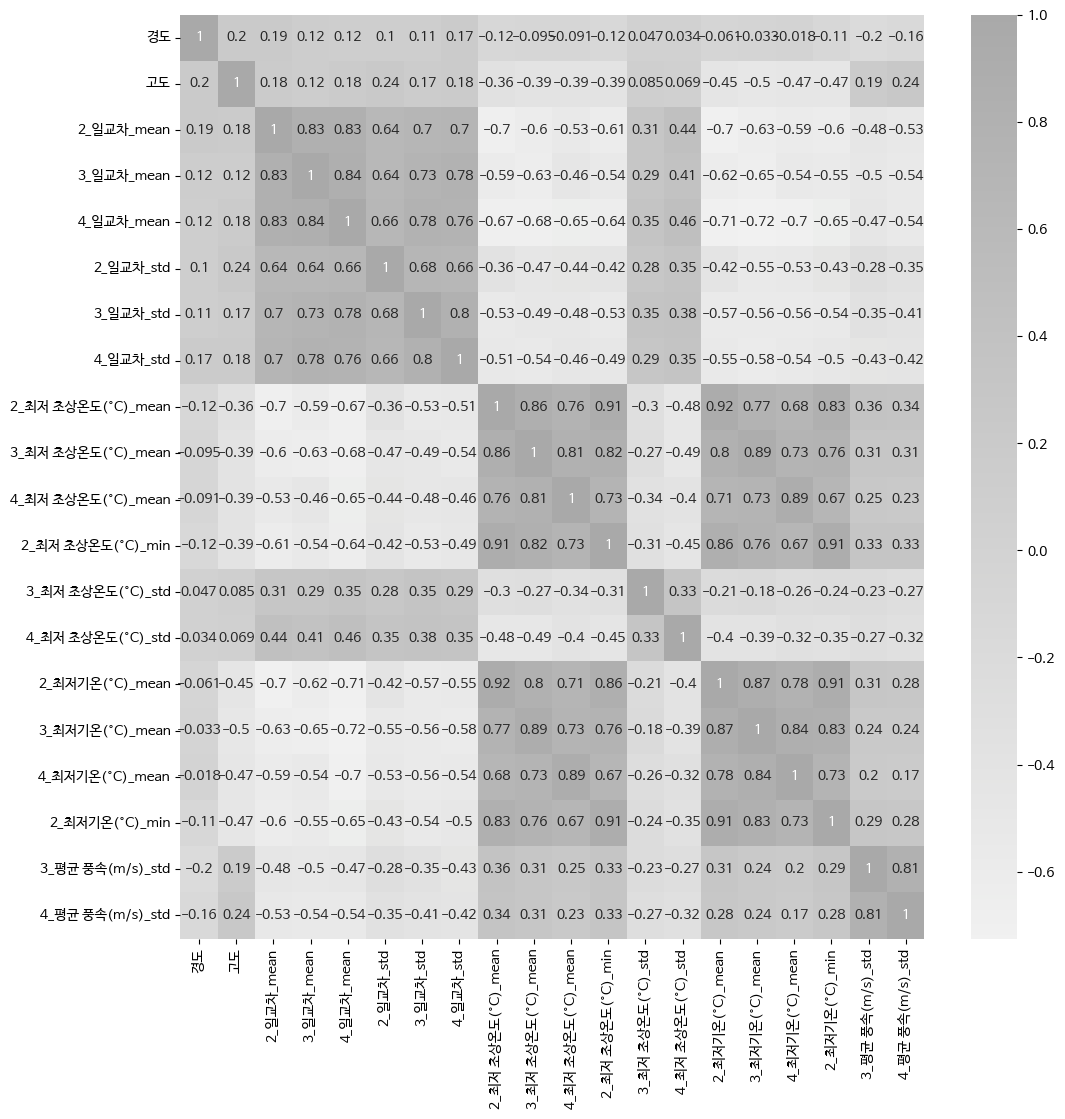

In [ ]:
plt.figure(figsize=(12, 12))
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(data1[selected_features].corr(), annot=True, cmap=cmap)
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    data1[selected_features].values, i) for i in range(data1[selected_features].shape[1])]
vif["features"] = data1[selected_features].columns
vif.sort_values(by='VIF Factor', inplace = True)

In [ ]:
list(vif.features)

['고도',
 '3_평균 풍속(m/s)_std',
 '4_평균 풍속(m/s)_std',
 '4_최저 초상온도(°C)_std',
 '3_최저 초상온도(°C)_std',
 '2_일교차_std',
 '3_최저기온(°C)_mean',
 '3_최저 초상온도(°C)_mean',
 '4_최저 초상온도(°C)_mean',
 '4_일교차_std',
 '3_일교차_std',
 '2_최저기온(°C)_mean',
 '2_최저기온(°C)_min',
 '2_일교차_mean',
 '4_일교차_mean',
 '3_일교차_mean',
 '2_최저 초상온도(°C)_min',
 '4_최저기온(°C)_mean',
 '2_최저 초상온도(°C)_mean',
 '경도']

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# List of selected features
selected_features = ['고도',
#  '3_평균 풍속(m/s)_mean',
'2_평균 풍속(m/s)_mean',
#  '4_평균 풍속(m/s)_std',
#  '4_최저 초상온도(°C)_std',
#  '3_최저 초상온도(°C)_std',
# #  '2_일교차_mean',
 '3_최저기온(°C)_mean',
# #  '3_최저 초상온도(°C)_mean',
# #  '4_최저 초상온도(°C)_mean',
# #  '4_일교차_std',
# #  '3_일교차_std',
 '2_최저기온(°C)_mean',
# #  '2_최저기온(°C)_min',
# #  '4_일교차_mean',
#  '2_최저 초상온도(°C)_min',
#  '4_최저기온(°C)_mean',
#  '2_최저 초상온도(°C)_mean',
]

# selected_features = [
#  '3_최저 초상온도(°C)_std',
#  '3_최저기온(°C)_mean',
#  '3_최저 초상온도(°C)_mean',
#  '3_일교차_std',
#  '2_일교차_mean',
#  '2_최저기온(°C)_mean',
#  '2_최저기온(°C)_min',
#  '경도']

# Create a subset DataFrame with the selected features
subset_data = data1[selected_features]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(subset_data.values, i) for i in range(subset_data.shape[1])]
vif["Features"] = selected_features  # Assign the feature names to the DataFrame
vif = vif.sort_values(by='VIF Factor', ascending=False)
print(vif)


   VIF Factor           Features
1    4.562958  2_평균 풍속(m/s)_mean
2    3.433958    3_최저기온(°C)_mean
3    3.084379    2_최저기온(°C)_mean
0    2.747050                 고도


   VIF Factor           Features
1   32.235209  3_평균 풍속(m/s)_mean
2   30.434513  2_평균 풍속(m/s)_mean
3    3.558238    3_최저기온(°C)_mean
4    3.249521    2_최저기온(°C)_mean
0    2.796647                 고도

In [ ]:
final_selected_var = list(vif.Features)

# 2.서리 예측 모델링

#### 2.1전체지점별로 모델링

In [1]:
# train, test나누는것도 random /  5 fold => 시계열 고려 X

# residual을 돌려? 기온 decompos - trend, 계절성 제거 => 5 fold => 랜포

In [ ]:
def MAE_cv(model, X_train, X_test, y_train, y_test):
    tscv = TimeSeriesSplit(n_splits=5)
    mae_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(x_train), start=1), desc=f'{model_name} Cross Validations...', total=5):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        clf = model.fit(X_train_fold, y_train_fold)
        pred = clf.predict(X_test_fold)
        mae = mean_absolute_error(y_test_fold, pred)
        mae_list.append(mae)
    return model_name, mae_list

def print_mae_score(model, X_train, X_test, y_train, y_test):
    model_name, score = MAE_cv(model, X_train, X_test, y_train, y_test)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} mae: {r:.4f}')
    print(f'\n{model_name} mean mae: {np.mean(score):.4f}')
    print('=' * 40)
    return model_name, np.mean(score)

reg = LinearRegression()
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha=0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)
catboost = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, loss_function='MAE', verbose=False)
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5)
histboost = HistGradientBoostingRegressor()
GBR = GradientBoostingRegressor()


In [ ]:
data1.tail(258)

,지점,서리끝,서리끝(평비),365,연,위도,경도,고도,2_일교차_mean,3_일교차_mean,...,3_평균 전운량(1/10)_std,4_평균 전운량(1/10)_std,2_평균 풍속(m/s)_mean,3_평균 풍속(m/s)_mean,4_평균 풍속(m/s)_mean,2_평균 풍속(m/s)_std,3_평균 풍속(m/s)_std,4_평균 풍속(m/s)_std,해양_0.0,해양_1.0
1664,제주,2019-02-12,-2.0,43,2019,33.521800,126.553833,16.930000,5.360714,6.854839,...,2.619895,3.130561,3.010714,3.461290,2.950000,0.992318,1.241149,0.911516,0,1
1665,제주,2022-01-21,-24.0,21,2022,33.521800,126.553833,16.930000,5.753571,7.609677,...,3.361640,3.052837,4.060714,3.241935,2.816667,1.346969,1.071688,0.852616,0,1
1666,제주,2023-02-27,13.0,58,2023,33.521800,126.553833,16.930000,6.296429,7.851613,...,3.289825,3.365616,3.096429,2.687097,3.600000,1.029377,0.903232,1.171795,0,1
1667,금산,1989-04-29,5.0,119,1989,36.691567,127.570400,157.286667,11.232143,13.109677,...,3.132634,2.868978,1.007143,1.432258,1.313333,0.688492,0.675469,0.536742,1,0
1668,금산,1990-04-27,3.0,117,1990,36.691567,127.570400,157.286667,8.942857,12.829032,...,3.884989,3.308123,0.850000,1.277419,1.516667,0.547384,0.754855,0.972052,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,충주,2010-04-17,4.0,107,2010,36.970500,127.952500,114.850000,9.835714,8.916129,...,3.015266,3.374584,1.364286,2.032258,2.106667,0.735962,0.857666,0.928823,1,0
1918,충주,2011-04-13,0.0,103,2011,36.970500,127.952500,114.850000,12.982143,12.287097,...,2.242586,3.271199,1.278571,2.167742,1.930000,0.668529,0.822754,0.565777,1,0
1919,충주,2012-04-08,-5.0,99,2012,36.970500,127.952500,114.850000,12.327586,10.035484,...,3.112834,3.351642,1.613793,2.135484,2.183333,0.850934,0.944298,0.985090,1,0
1920,충주,2013-04-13,0.0,103,2013,36.970500,127.952500,114.850000,10.600000,14.000000,...,2.215444,2.864364,1.675000,1.761290,2.180000,0.939907,0.713992,0.825624,1,0


In [ ]:
x_train = data1[final_selected_var].iloc[:1667 ,:]
y_train = data1['365'][:1667]

x_test = data1[final_selected_var].iloc[1667: ,:]                      # 금산부터 test set
y_test = data1['365'][1667:]

In [ ]:
# Predict
models = []
scores = []
for model in [reg,ridge,lasso,Enet,catboost,model_xgb,model_lgb,histboost,GBR]:
    model_name, mean_score = print_mae_score(model, x_train, x_test, y_train, y_test)
    models.append(model_name)
    scores.append(mean_score)

LinearRegression Cross Validations...: 100%|██████████| 5/5 [00:00<00:00, 82.73it/s]


1 FOLDS: LinearRegression mae: 12.1930
2 FOLDS: LinearRegression mae: 11.8009
3 FOLDS: LinearRegression mae: 18.5058
4 FOLDS: LinearRegression mae: 18.3508
5 FOLDS: LinearRegression mae: 17.8101

LinearRegression mean mae: 15.7321


Ridge Cross Validations...: 100%|██████████| 5/5 [00:00<00:00, 230.89it/s]


1 FOLDS: Ridge mae: 12.1937
2 FOLDS: Ridge mae: 11.7988
3 FOLDS: Ridge mae: 18.5065
4 FOLDS: Ridge mae: 18.3514
5 FOLDS: Ridge mae: 17.8103

Ridge mean mae: 15.7321


Lasso Cross Validations...: 100%|██████████| 5/5 [00:00<00:00, 144.75it/s]


1 FOLDS: Lasso mae: 12.1940
2 FOLDS: Lasso mae: 11.7980
3 FOLDS: Lasso mae: 18.5089
4 FOLDS: Lasso mae: 18.3526
5 FOLDS: Lasso mae: 17.8113

Lasso mean mae: 15.7330


ElasticNet Cross Validations...: 100%|██████████| 5/5 [00:00<00:00, 198.12it/s]


1 FOLDS: ElasticNet mae: 12.2016
2 FOLDS: ElasticNet mae: 11.7623
3 FOLDS: ElasticNet mae: 18.5288
4 FOLDS: ElasticNet mae: 18.3738
5 FOLDS: ElasticNet mae: 17.8175

ElasticNet mean mae: 15.7368


CatBoostRegressor Cross Validations...: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


1 FOLDS: CatBoostRegressor mae: 12.9539
2 FOLDS: CatBoostRegressor mae: 12.5734
3 FOLDS: CatBoostRegressor mae: 19.9043
4 FOLDS: CatBoostRegressor mae: 19.3527
5 FOLDS: CatBoostRegressor mae: 16.6124

CatBoostRegressor mean mae: 16.2793


XGBRegressor Cross Validations...: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


1 FOLDS: XGBRegressor mae: 13.7820
2 FOLDS: XGBRegressor mae: 13.8224
3 FOLDS: XGBRegressor mae: 22.5498
4 FOLDS: XGBRegressor mae: 24.2757
5 FOLDS: XGBRegressor mae: 19.2188

XGBRegressor mean mae: 18.7298


LGBMRegressor Cross Validations...:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 282, number of used features: 4
[LightGBM] [Info] Start training from score 100.638298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

LGBMRegressor Cross Validations...:  20%|██        | 1/5 [00:00<00:01,  2.69it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  40%|████      | 2/5 [00:00<00:01,  2.60it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  60%|██████    | 3/5 [00:01<00:00,  2.53it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...:  80%|████████  | 4/5 [00:01<00:00,  2.57it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor Cross Validations...: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

HistGradientBoostingRegressor Cross Validations...: 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]


1 FOLDS: HistGradientBoostingRegressor mae: 12.8438
2 FOLDS: HistGradientBoostingRegressor mae: 13.7054
3 FOLDS: HistGradientBoostingRegressor mae: 20.5296
4 FOLDS: HistGradientBoostingRegressor mae: 21.9596
5 FOLDS: HistGradientBoostingRegressor mae: 18.4789

HistGradientBoostingRegressor mean mae: 17.5034


GradientBoostingRegressor Cross Validations...: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]

1 FOLDS: GradientBoostingRegressor mae: 12.2592
2 FOLDS: GradientBoostingRegressor mae: 12.9497
3 FOLDS: GradientBoostingRegressor mae: 20.9208
4 FOLDS: GradientBoostingRegressor mae: 20.6160
5 FOLDS: GradientBoostingRegressor mae: 17.7345

GradientBoostingRegressor mean mae: 16.8960


#### 2.2지점별로 모델링
- 라쏘
- 릿지 / 베이지안 릿지
- xgboost
- randomforest